# Workflow

En esta práctica vamos a aplicar lo aprendido en esta asignatura para crear un flujo que automatice la descarga, análisis y publicación de los datos utilizando distintas herramientas como Zenodo, github y librerías de python para el análisis de datos

### Librerías necesarias para la práctica

```python
import xml.etree.ElementTree as ET # module implements a simple and efficient API for parsing and creating XML data.
import requests
import json # zenedo devuelve todo en formato json
import zipfile # sirve para descomprir todo lo que haya 
```

### Elementos necesarios
* Al menos un fichero CSV
* Un script de análisis de datos en CSV (Publicado en Github)


# Publicación de datos iniciales

Utilizando Zenodo, de forma manual, publicar los datos que se vayan a utilizar.

<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>Utilizar Communities para localizar más facilmente los datos</p>
</div>

# Pasos seguidos

- 1.- Descargamos un dataset que nos interese (.csv)
- 2.- Generamos un script con código de python (He creado un histograma de las alturas para los juagadores de basket)
- 3.- Creamos una comunidad en Zenodo (AdriaNovaPages_comunity)
- 4.- Subimos el csv de local a Zenodo, haciendo referencia a la comunidad.
- 5.- Subimos el script que lo tenemos en la cuenta de github (repositorio Workflow_2023)

**NOMBRE DE LA COMUNIDAD:** AdriaNovaPages_comunity

# Publicación de script de Análisis

En Github + Zenodo

- 5.- Subimos el script que lo tenemos en la cuenta de github (repositorio Workflow_2023) a ZENODO

# Descarga de datos

Desde Zenodo, utilizando los métodos conocidos (OAI-PMH, API)

Pista: url+'?verb=ListRecords&set=nombre_set

In [1]:
import requests
import json
import csv
from datetime import datetime
import xml.etree.cElementTree as ET

Un par de funciones para búsqueda

oai_set -> es la comunidad, filtra por comunidad zenodo

In [2]:
# ZENODO OAI2D
oai_url = 'https://sandox.zenodo.org/oai2d'

In [3]:
def search_dataset(url,oai_set,metadata_format):
    """Search the datasets identifiers in the defined set
        Parameters
        ----------
        url : string
            OAI-PMH endpoint url
        oai_set : string
            OAI-PMH set where the datasets will be searched
        metadata_format : string
            Selected metadata format to search
        Returns
        -------
        dataset_ids : array 
            Dataset IDs
    """
    #Define bounds to search in specific set
    bounds = "&set="+oai_set
    oai = requests.get(url+'?verb=ListRecords&metadataPrefix='+metadata_format+bounds)

    oaiTree = ET.ElementTree(ET.fromstring(oai.text.encode('utf-8')))
    item = oaiTree.findall('.//{http://datacite.org/schema/kernel-3}identifier')
    return item

In [4]:
# FUNCIÓN QUE TE SACA LOS FORMATOS DE LOS METADATOS OAI
def get_oai_metadata_formats(url):
    """Lists the available metadata formats
        Parameters
        ----------
        url : string
            OAI-PMH endpoint url
        Returns
        -------
        metadata_formats : 
            Name of the downloaded file(s).
    """
    metadata_formats = []
    oai_verb = '?verb=ListMetadataFormats'
    oai = requests.get(url + oai_verb) #Peticion al servidor
    xmlTree = ET.ElementTree(ET.fromstring(oai.text))
    iterator = xmlTree.iter()
    for elem in iterator:
        if (elem.tag == '{http://www.openarchives.org/OAI/2.0/}metadataPrefix'):
            metadata_formats.append(elem.text)
    return metadata_formats

para descargar los datos

In [5]:
def check_dataset(ids,api_url,tipo):
    """Checks if the available datasets satisfy the dates and location req
        Parameters
        ----------
        ids : array
            List of dataset ids
        api_url : string
            API to get dataset metadata
        tipo : string
            type of file to download
        Returns
        -------
        downloaded_datasets : array 
            List of downloaded datasets
    """
    list_of_files = []
    for i in ids: # Hay 3 archivos subidos por user-cdp
        response = requests.get('https://sandbox.zenodo.org/api/records', params={'q': i.text.split('.')[-1]})
        url_to_check = response.json()['hits']['hits'][0]['links']['latest']
        headers = {'accept': 'application/json', 'Content-Type': 'application/json'}
        metadata = requests.get(url_to_check, headers=headers)
        for e in metadata.json()['files']:
            print(e)
            if (".%s" % tipo) in e['filename']:
                file_name = e['filename'].replace('/','_')
                list_of_files.append(file_name)
                link = e['links']['download']
                with open(file_name, "wb") as f:
                    print("Downloading %s" % file_name)
                    response = requests.get(link, stream=True)
                    total_length = response.headers.get('content-length')
                    if total_length is None: # no content length header
                        f.write(response.content)
                    else:
                        dl = 0
                        total_length = int(total_length)
                        for data in response.iter_content(chunk_size=4096):
                            dl += len(data)
                            f.write(data)
                            done = int(50 * dl / total_length)
                            sys.stdout.write("\r[%s%s]" % ('=' * done, ' ' * (50-done)) )    
                            sys.stdout.flush()
      
    return list_of_files

Busco el dataset

In [6]:
import sys
#Searching datasets OAI-PMH
print("Searching datasets OAI-PMH")
oai_url = 'https://sandbox.zenodo.org/oai2d'
metadata_formats = get_oai_metadata_formats(oai_url)

#TODO hardcoded
print("Searching Datasets")
oai_set = 'user-adrianovapages_comunity' #OJO!! user - (poner la comunidad) user-AdriaNovaPages_comunity
dataset_list = search_dataset(oai_url,oai_set,'oai_datacite3')
print(dataset_list)

print("Checking/download Datasets")
api_url = 'https://doi.org/'

csv_files = check_dataset(dataset_list,api_url,'csv')
print(csv_files)

zip_files = check_dataset(dataset_list,api_url,'zip')
print(zip_files)

Searching datasets OAI-PMH
Searching Datasets
[<Element '{http://datacite.org/schema/kernel-3}identifier' at 0x10f0611c0>, <Element '{http://datacite.org/schema/kernel-3}identifier' at 0x10f09cc20>]
Checking/download Datasets
{'checksum': '1f648fdaae05d1b619cc7b05e442214e', 'filename': 'players_stats.csv', 'filesize': 80373, 'id': '7e2b9d8c-c576-453c-8b7a-bc6b270c7750', 'links': {'download': 'https://sandbox.zenodo.org/api/files/02f83fed-9c09-465a-9eca-9bda1f8726fd/players_stats.csv', 'self': 'https://sandbox.zenodo.org/api/deposit/depositions/1150484/files/7e2b9d8c-c576-453c-8b7a-bc6b270c7750'}}
{'checksum': '6cee1b171e7a2a1df5799c94e033218b', 'filename': 'adrianova8/Workflow_2023-branch.zip', 'filesize': 33858, 'id': '440d50ae-133d-45c1-97d3-e99e8ef42d09', 'links': {'download': 'https://sandbox.zenodo.org/api/files/425c2da8-58f1-4046-aee2-b113acbe27b3/adrianova8/Workflow_2023-branch.zip', 'self': 'https://sandbox.zenodo.org/api/deposit/depositions/1150516/files/440d50ae-133d-45c1-97d

In [7]:
ls

README.md                            ferag_csvprinter-1.01.zip
Workflow_resuelto2022.ipynb          nova_adrianova8_workflow.ipynb
adrianova8-Workflow_2023-3bb696d/    players_stats.csv*
adrianova8_Workflow_2023-branch.zip  plot.py
amt_2010.csv                         script.ipynb
ferag-csvprinter-59552e7/            script.py


In [8]:
import zipfile
import os
with zipfile.ZipFile("adrianova8_Workflow_2023-branch.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

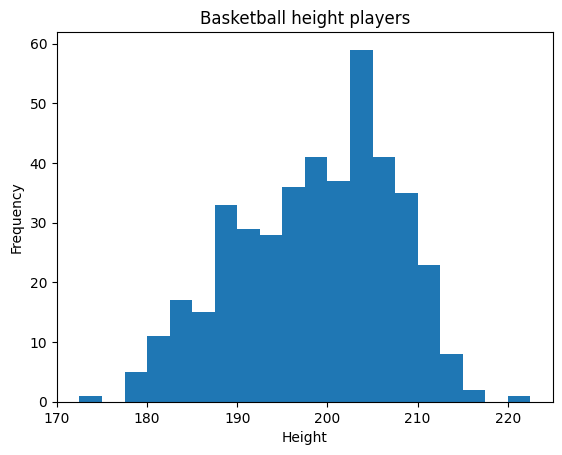

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('players_stats.csv')

# Generate two normal distributions
dist1 = data['Height']
n_bins = 20

# We can set the number of bins with the *bins* keyword argument.
plt.hist(dist1, bins=n_bins)
plt.title("Basketball height players")
plt.xlabel("Height")
plt.ylabel("Frequency")
plt.show()

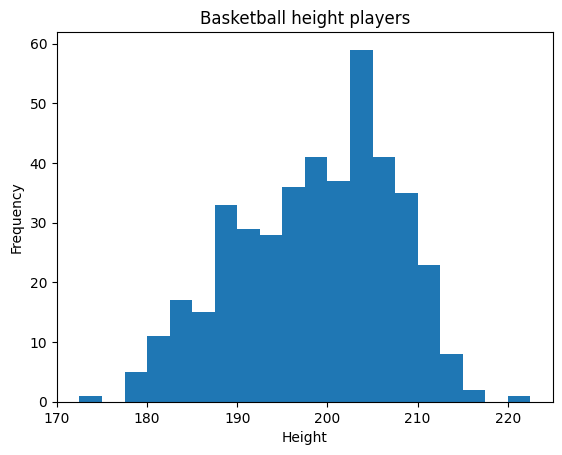

In [10]:
%run -i script.py players_stats.csv.csv

In [11]:
ls

README.md                            ferag_csvprinter-1.01.zip
Workflow_resuelto2022.ipynb          nova_adrianova8_workflow.ipynb
adrianova8-Workflow_2023-3bb696d/    players_stats.csv*
adrianova8_Workflow_2023-branch.zip  plot.py
amt_2010.csv                         script.ipynb
ferag-csvprinter-59552e7/            script.py


# Descarga de código

Desde Zenodo, utilizando los métodos conocidos (OAI-PMH, API)

<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>Zenodo guarda un zip con el código</p>
</div>

In [12]:
 #Searching code OAI-PMH
print("Searching software OAI-PMH")
oai_url = 'https://sandbox.zenodo.org/oai2d'
metadata_formats = get_oai_metadata_formats(oai_url)

#TODO hardcoded
print("Searching Software")
oai_set = 'user-adrianovapages_comunity'
dataset_list = search_dataset(oai_url,oai_set,'oai_datacite')
print(dataset_list)

print("Checking/download Datasets")
api_url = 'https://doi.org/'

zip_files = check_dataset(dataset_list,api_url,'zip') # comprobar la direccion de los ficheros donde los tienes publicsados y descargarlos
print(zip_files)

Searching software OAI-PMH
Searching Software
[<Element '{http://datacite.org/schema/kernel-3}identifier' at 0x11a840540>, <Element '{http://datacite.org/schema/kernel-3}identifier' at 0x11a842340>]
Checking/download Datasets
{'checksum': '1f648fdaae05d1b619cc7b05e442214e', 'filename': 'players_stats.csv', 'filesize': 80373, 'id': '7e2b9d8c-c576-453c-8b7a-bc6b270c7750', 'links': {'download': 'https://sandbox.zenodo.org/api/files/02f83fed-9c09-465a-9eca-9bda1f8726fd/players_stats.csv', 'self': 'https://sandbox.zenodo.org/api/deposit/depositions/1150484/files/7e2b9d8c-c576-453c-8b7a-bc6b270c7750'}}
{'checksum': '6cee1b171e7a2a1df5799c94e033218b', 'filename': 'adrianova8/Workflow_2023-branch.zip', 'filesize': 33858, 'id': '440d50ae-133d-45c1-97d3-e99e8ef42d09', 'links': {'download': 'https://sandbox.zenodo.org/api/files/425c2da8-58f1-4046-aee2-b113acbe27b3/adrianova8/Workflow_2023-branch.zip', 'self': 'https://sandbox.zenodo.org/api/deposit/depositions/1150516/files/440d50ae-133d-45c1-97d

In [13]:
import zipfile
with zipfile.ZipFile("adrianova8_Workflow_2023-branch.zip","r") as zip_ref:
    zip_ref.extractall(".")

In [14]:
ls adrianova8-Workflow_2023-3bb696d

players_stats.csv  script.py


# Análisis de los datos

Producir fichero: Otro CSV, imagen, etc

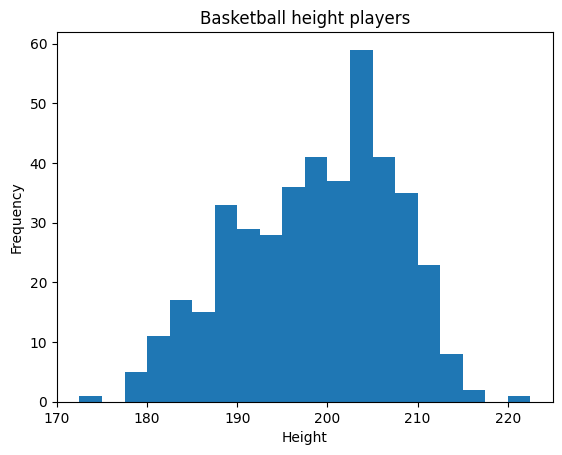

In [15]:
%run -i adrianova8-Workflow_2023-3bb696d/script.py players_stats.csv

# Publicación de los Datos

Utilizando la API de Zenodo

In [3]:
import requests

In [6]:
ACCESS_TOKEN = 'uPwIk2kwGcbnCNa83w8PKhwMolYQ420hd8SDKL5ZEFjyQMU1iBLjGOaJUK9s'
r = requests.get('https://sandbox.zenodo.org/api/deposit/depositions',params={'access_token': ACCESS_TOKEN})
r.status_code
r.json()

[{'conceptdoi': '10.5072/zenodo.1150515',
  'conceptrecid': '1150515',
  'created': '2023-01-23T16:25:13.487634',
  'doi': '10.5072/zenodo.1150516',
  'doi_url': 'https://doi.org/10.5072/zenodo.1150516',
  'files': [{'checksum': '6cee1b171e7a2a1df5799c94e033218b',
    'filename': 'adrianova8/Workflow_2023-branch.zip',
    'filesize': 33858,
    'id': '440d50ae-133d-45c1-97d3-e99e8ef42d09',
    'links': {'download': 'https://sandbox.zenodo.org/api/files/425c2da8-58f1-4046-aee2-b113acbe27b3/adrianova8/Workflow_2023-branch.zip',
     'self': 'https://sandbox.zenodo.org/api/deposit/depositions/1150516/files/440d50ae-133d-45c1-97d3-e99e8ef42d09'}}],
  'id': 1150516,
  'links': {'badge': 'https://sandbox.zenodo.org/badge/doi/10.5072/zenodo.1150516.svg',
   'bucket': 'https://sandbox.zenodo.org/api/files/fc72febf-f3d8-4f8f-8df2-c4330e26505a',
   'conceptbadge': 'https://sandbox.zenodo.org/badge/doi/10.5072/zenodo.1150515.svg',
   'conceptdoi': 'https://doi.org/10.5072/zenodo.1150515',
   'dis

+ EN ESTE APARTADO HE TENIDO PROBLEMAS PARA PUBLICAR LOS DATOS A ZENODO, YA QUE CONSTANTEMENTE ME DABA COMO SALIDA EL ERROR 403 (ACCESO DENEGADO), HE BUSCADO COMO HACERLO DESDE LA API DE ZENDO, POR STACKOVERFLOW Y NO LO HE CONSEGUIDO. ME GUSTARIA SABER COMO SE HACE UNA VEZ PASADA LA CORRECIÓN PARA APRENDER DE ELLO. 

In [10]:
deposition_id = "1150516"
data = {'name': 'adrianova8/Workflow_2023-branch.zip'}
files = {'file': open('script.py', 'rb')}
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36'}
#headers = {"Content-Type": "application/json"}
r = requests.post('https://sandbox.zenodo.org/api/deposit/depositions/1150516/files',
                  params={'access_token': ACCESS_TOKEN}, data=data,
                  files=files, headers = headers)
r.text 

'{"status": 403, "message": null}'

In [57]:
data = {
    'metadata': {
        'title': 'My first upload',
        'upload_type': 'dataset',
        'description': 'This is my first upload',
        'creators': [{'name': 'Adria, Nova',
                      'affiliation': 'UC'}]
    }
}
r = requests.put('https://sandbox.zenodo.org/api/deposit/depositions/%s' % deposition_id,
                 params={'access_token': ACCESS_TOKEN}, data=json.dumps(data),
                 headers=headers)
r.status_code

415